In [4]:
import sys
import os
from pathlib import Path

# Add src
project_root = Path(os.getcwd()).parent.parent
sys.path.append(str(project_root / "src"))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from logging_config import setup_logging
import pyarrow.parquet as pq
import logging

# Setup logging and seaborn
setup_logging()
sns.set_palette("colorblind")
np.random.seed(42)

In [6]:
# Load the data
file_path = project_root / "data" / "vspdb_vs_profiles.parquet"
table = pq.read_table(file_path)
df = table.to_pandas()
logging.info(f"Data loaded with shape: {df.shape}")

2025-09-04 16:24:08,981 [INFO] Data loaded with shape: (354220, 3)


In [7]:
# Convert data
profiles_dict = {
    metadata_id: group.sort_values("depth")
    .drop(columns=["velocity_metadata_id"])
    .reset_index(drop=True)
    for metadata_id, group in df.groupby("velocity_metadata_id")
}

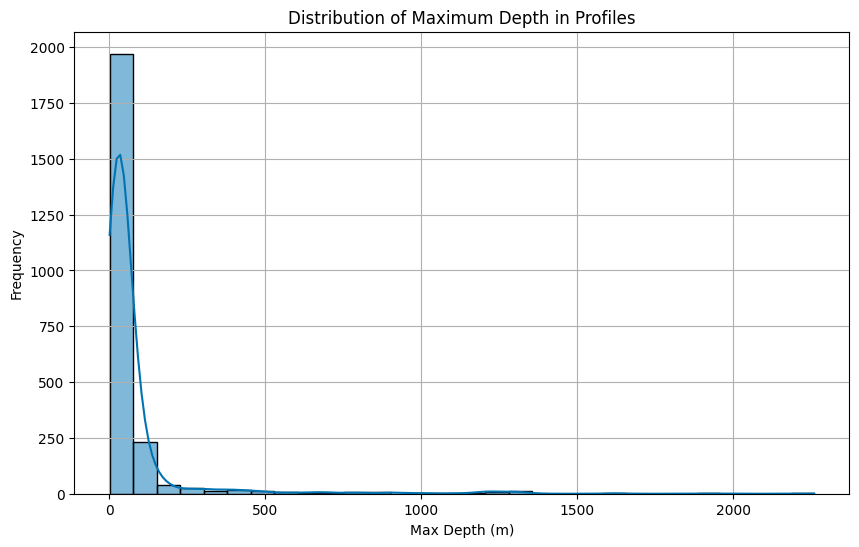

In [8]:
## Distribution of max depth in each profile
max_depths = [profile["depth"].max() for profile in profiles_dict.values()]
plt.figure(figsize=(10, 6))
sns.histplot(max_depths, bins=30, kde=True)
plt.title("Distribution of Maximum Depth in Profiles")
plt.xlabel("Max Depth (m)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [9]:
# Compute Vs30 for each profile
def compute_vs30(profile):
    # Ensure the profile is sorted by depth
    profile = profile.sort_values("depth").reset_index(drop=True)

    # Initialize variables
    total_depth = 0
    weighted_velocity_sum = 0

    # Iterate through the layers to compute Vs30
    for i in range(len(profile) - 1):
        layer_top = profile.loc[i, "depth"]
        layer_bottom = profile.loc[i + 1, "depth"]
        layer_velocity = profile.loc[i, "vs_value"]

        layer_thickness = layer_bottom - layer_top

        if total_depth + layer_thickness >= 30:
            # Only take the portion of the layer that contributes to the first 30m
            remaining_depth = 30 - total_depth
            weighted_velocity_sum += layer_velocity * remaining_depth
            total_depth += remaining_depth
            break
        else:
            weighted_velocity_sum += layer_velocity * layer_thickness
            total_depth += layer_thickness

    # If the profile is shallower than 30m, use the average velocity of the available depth
    if total_depth < 30:
        return weighted_velocity_sum / total_depth if total_depth > 0 else None

    return weighted_velocity_sum / 30

In [10]:
vs30 = [compute_vs30(profile) for profile in profiles_dict.values()]

2025-09-04 16:48:46,135 [INFO] Vs30 Statistics: Mean=472.17, Median=352.23, Std=342.64
2025-09-04 16:48:46,145 [INFO] Vs30 Min=30.48, Max=2830.07


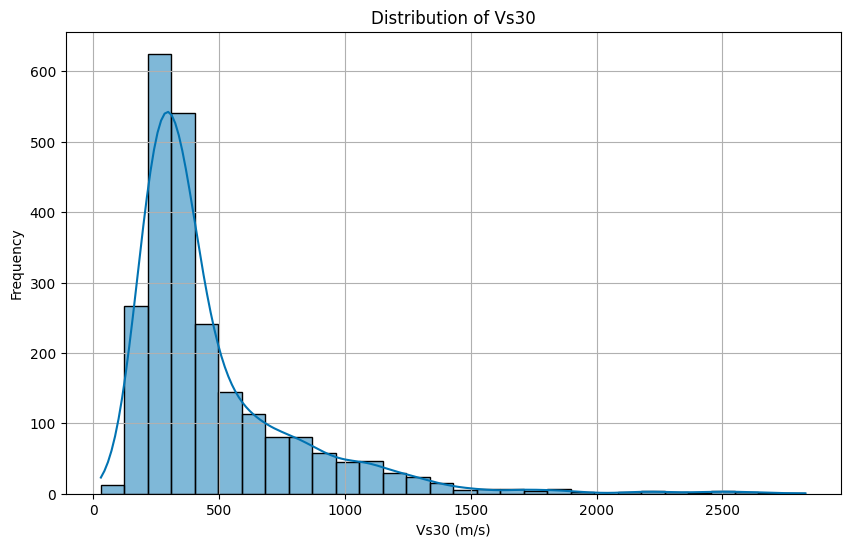

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(vs30, bins=30, kde=True)
plt.title("Distribution of Vs30")
plt.xlabel("Vs30 (m/s)")
plt.ylabel("Frequency")
plt.grid()

# Print statistics of Vs30
vs30_array = np.array(vs30)
logging.info(
    f"Vs30 Statistics: Mean={np.nanmean(vs30_array):.2f}, Median={np.nanmedian(vs30_array):.2f}, Std={np.nanstd(vs30_array):.2f}"
)
logging.info(f"Vs30 Min={np.nanmin(vs30_array):.2f}, Max={np.nanmax(vs30_array):.2f}")

In [12]:
# Compute Vs at any depth Z
def compute_vs_at_depth(profile, depth):
    # Ensure the profile is sorted by depth
    profile = profile.sort_values("depth").reset_index(drop=True)

    # Initialize variables
    total_depth = 0
    weighted_velocity_sum = 0

    # Iterate through the layers to compute Vs at depth Z
    for i in range(len(profile) - 1):
        layer_top = profile.loc[i, "depth"]
        layer_bottom = profile.loc[i + 1, "depth"]
        layer_velocity = profile.loc[i, "vs_value"]

        layer_thickness = layer_bottom - layer_top

        if total_depth + layer_thickness >= depth:
            # Only take the portion of the layer that contributes to the first Z meters
            remaining_depth = depth - total_depth
            weighted_velocity_sum += layer_velocity * remaining_depth
            total_depth += remaining_depth
            break
        else:
            weighted_velocity_sum += layer_velocity * layer_thickness
            total_depth += layer_thickness

    # If the profile is shallower than Z meters, use the average velocity of the available depth
    if total_depth < depth:
        return weighted_velocity_sum / total_depth if total_depth > 0 else None

    return weighted_velocity_sum / depth

In [13]:
vs_1km = [compute_vs_at_depth(profile, 1000) for profile in profiles_dict.values()]
vs_2km = [compute_vs_at_depth(profile, 2000) for profile in profiles_dict.values()]

In [14]:
len(vs_1km), len(vs_2km), len(vs30), len(profiles_dict)

(2369, 2369, 2369, 2369)

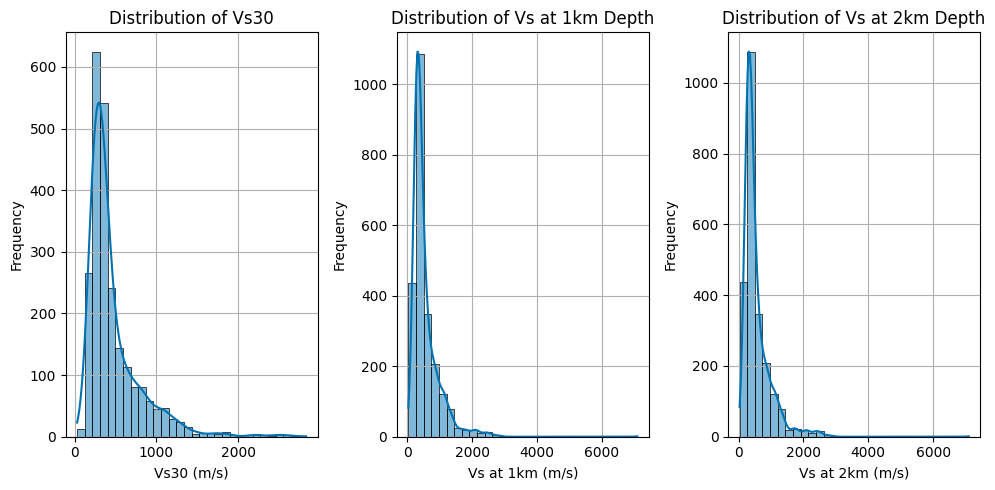

In [15]:
# Do three subfigures for each vs_depth we computed
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.histplot(vs30, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Vs30")
axes[0].set_xlabel("Vs30 (m/s)")
axes[0].set_ylabel("Frequency")
axes[0].grid()
sns.histplot(vs_1km, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Vs at 1km Depth")
axes[1].set_xlabel("Vs at 1km (m/s)")
axes[1].set_ylabel("Frequency")
axes[1].grid()
sns.histplot(vs_2km, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Vs at 2km Depth")
axes[2].set_xlabel("Vs at 2km (m/s)")
axes[2].set_ylabel("Frequency")
axes[2].grid()
plt.tight_layout()
plt.show()

In [16]:
# Calculate the two-way travel time profiles
def Vs_to_tts(profile):
    profile = profile.sort_values("depth").reset_index(drop=True)
    profile["tts"] = 2 * (
        profile["depth"].diff().fillna(profile["depth"]) / profile["vs_value"]
    )
    profile["tts"] = profile["tts"].cumsum()
    return profile


# Try
tts_profiles = {
    metadata_id: Vs_to_tts(profile) for metadata_id, profile in profiles_dict.items()
}


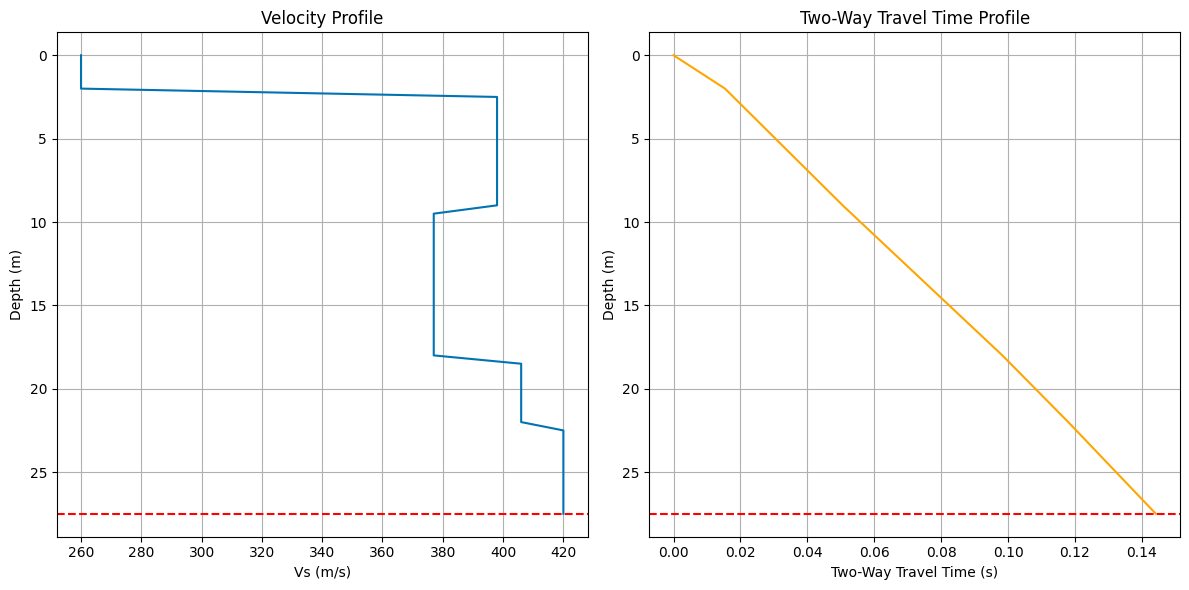

In [ ]:
idx = np.random.choice(list(profiles_dict.keys()), size=1, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(profiles_dict[idx[0]]["vs_value"], profiles_dict[idx[0]]["depth"])
ax[0].axhline(
    profiles_dict[idx[0]]["depth"].max(), color="red", linestyle="--", label="Max Depth"
)
ax[0].set_title("Velocity Profile")
ax[0].set_xlabel("Vs (m/s)")
ax[0].set_ylabel("Depth (m)")
ax[0].invert_yaxis()
ax[0].grid()

ax[1].plot(tts_profiles[idx[0]]["tts"], tts_profiles[idx[0]]["depth"], color="orange")
ax[1].axhline(
    tts_profiles[idx[0]]["depth"].max(), color="red", linestyle="--", label="Max Depth"
)
ax[1].set_title("Two-Way Travel Time Profile")
ax[1].set_xlabel("Two-Way Travel Time (s)")
ax[1].set_ylabel("Depth (m)")
ax[1].invert_yaxis()
ax[1].grid()
plt.tight_layout()
plt.show()


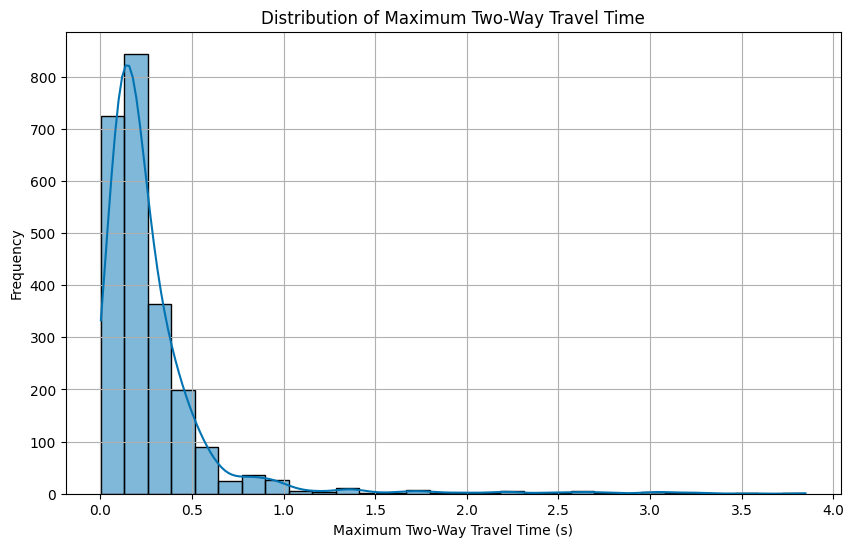

In [93]:
# Statistics on tts

## Distribution of max tts in each profile
max_tts = [profile["tts"].max() for profile in tts_profiles.values()]
plt.figure(figsize=(10, 6))
sns.histplot(max_tts, bins=30, kde=True)
plt.title("Distribution of Maximum Two-Way Travel Time")
plt.xlabel("Maximum Two-Way Travel Time (s)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

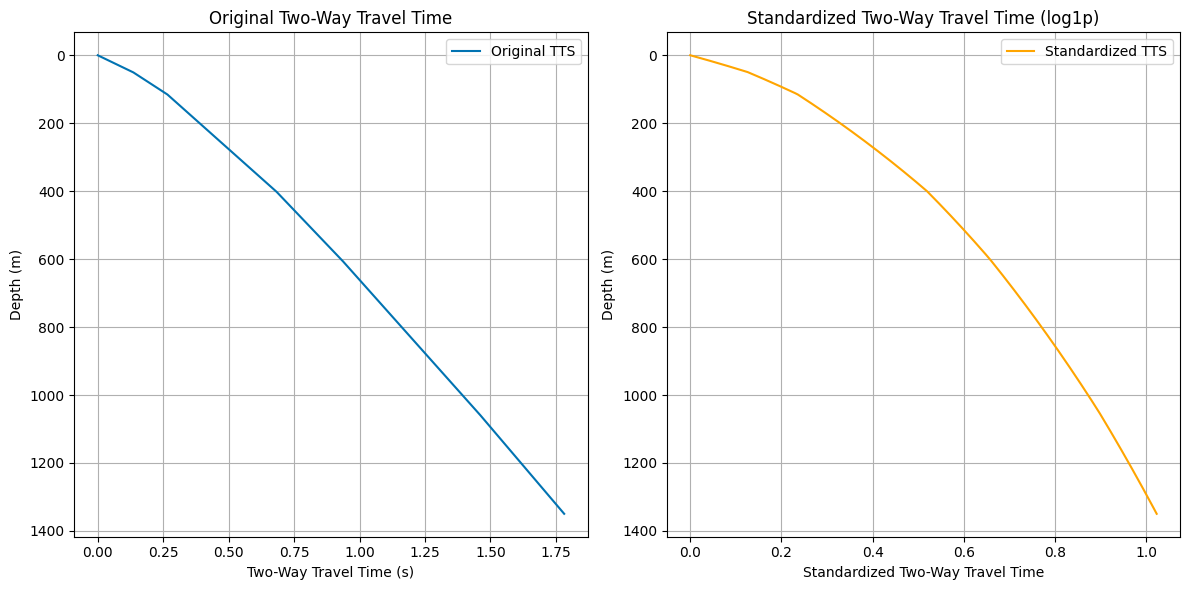

In [94]:
# Understanding the standarization we are doing with log1p

standardized_tts = {
    metadata_id: {
        "depth": profile["depth"],
        "standardized_tts": np.log1p(profile["tts"]),
    }
    for metadata_id, profile in tts_profiles.items()
}


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(
    x=tts_profiles[1]["tts"], y=tts_profiles[1]["depth"], label="Original TTS", ax=ax[0]
)
sns.lineplot(
    x=standardized_tts[1]["standardized_tts"],
    y=standardized_tts[1]["depth"],
    label="Standardized TTS",
    color="orange",
    ax=ax[1],
)
ax[0].set_title("Original Two-Way Travel Time")
ax[0].set_xlabel("Two-Way Travel Time (s)")
ax[0].set_ylabel("Depth (m)")
ax[0].invert_yaxis()
ax[0].grid()
ax[1].set_title("Standardized Two-Way Travel Time (log1p)")
ax[1].set_xlabel("Standardized Two-Way Travel Time")
ax[1].set_ylabel("Depth (m)")
ax[1].invert_yaxis()
ax[1].grid()
plt.tight_layout()
plt.show()


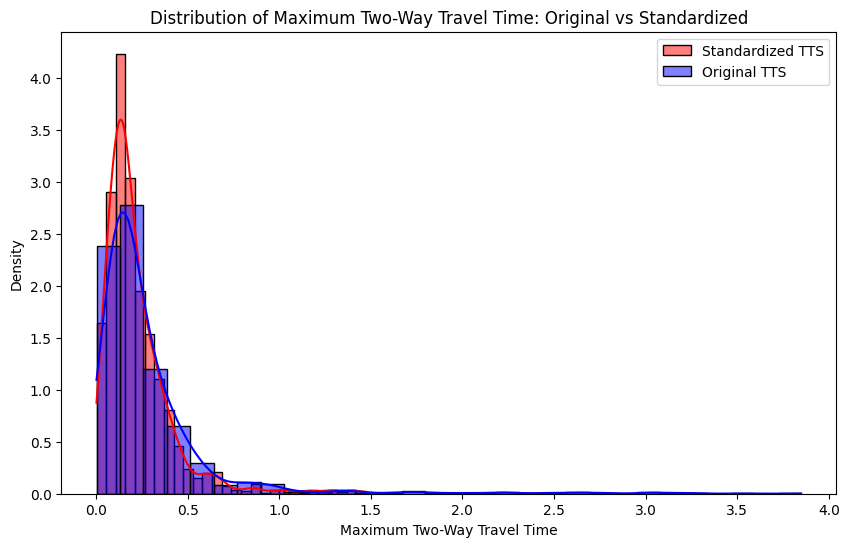

In [95]:
## Distribution of max standardized tts in each profile compared with max original tts
max_standardized_tts = [
    standardized_tts[metadata_id]["standardized_tts"].max()
    for metadata_id in standardized_tts
]
max_original_tts = [profile["tts"].max() for profile in tts_profiles.values()]

plt.figure(figsize=(10, 6))
sns.histplot(
    max_standardized_tts,
    bins=30,
    kde=True,
    color="red",
    label="Standardized TTS",
    stat="density",
)
sns.histplot(
    max_original_tts,
    bins=30,
    kde=True,
    color="blue",
    label="Original TTS",
    stat="density",
    alpha=0.5,
)
plt.title("Distribution of Maximum Two-Way Travel Time: Original vs Standardized")
plt.xlabel("Maximum Two-Way Travel Time")
plt.ylabel("Density")
plt.legend()
plt.show()